## PET Component Accuracy Testing for ET_test_data_Clay_center, Penman Method
This notebook loads hundreds of rows of input parameters and "hand-calculated" ET values from the ET_test_data_Clay_center spreadsheet, then runs the new PET component with the Penman-Monteith method using the excel input parameters and compares the PET-component-predicted results with the OBSERVED ET-per-day values given by the spreadsheets. Kc (Crop coefficient) values from the KC Excel sheet are factored into this notebook to assess PET more extensively with vegetation considered. A regression analysis is run to determine the correctness of the formulas used in the PET component.

### General Summary of Results
The Penman-Monteith method in the PET component is highly accurate for predicting real-world PET data, achieving an NSE of 0.82, an RMSE of only ~1.2, and a near-1.0 slope linear fit when PET component-calculated data points are plotted against observed/measured data points from the Excel sheet.

In [1]:
import numpy as np
import xlrd
from landlab.components import Radiation     # radiation component

from landlab import RasterModelGrid
from landlab.components import PotentialEvapotranspiration    #Potential Evapotranspiration component 

from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid

%matplotlib inline

import matplotlib.pyplot as plt

plt.show()

### IMPORTANT: Adjust DOY range here
A lot of the ET values in this dataset are actually 0.0, with non-zero ET values being consistently present from approx days 70 to 300.
It might be wise to adjust the variables below, scatter_lb and scatter_ub, to limit consideration of the model's accuracy ONLY to data existing within a range of days.

By default, the lower bound will be day 0, and the upper bound will be day 364.

In [2]:
# Lower, upper bounds of data. Can be set anywhere from 0 to 364
scatter_lb = 0
scatter_ub = 364

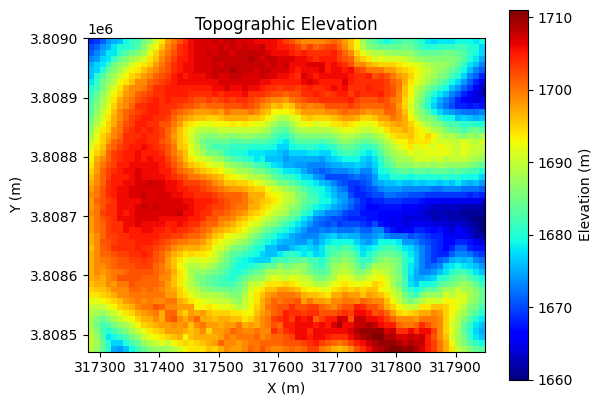

In [3]:
(watershed,z)=read_esri_ascii('Hugo_ws_10m.asc', name='topographic__elevation')


imshow_grid(watershed,'topographic__elevation', plot_name = 'Topographic Elevation', 
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'), 
            cmap = 'jet')

##### Define Nash-Sutcliffe Efficiency Function

In [4]:
# Nash Sutcliffe Efficiency formula function
def nse(observed, predictions):
    if (len(observed) != len(predictions)):
        print("ERROR: Observations and predictions are not equal in length")
        return

    num_sum = 0
    den_sum = 0
    observed_sum = 0
    for t in observed:
        observed_sum += t
    
    observed_avg = observed_sum / (len(observed));
    for t in range(len(observed)):
        num_sum += (observed[t] - predictions[t]) ** 2
        den_sum += (observed[t] - observed_avg) ** 2

    return 1 - (num_sum / den_sum)

##### Define RMSE formula function

In [5]:
# Root mean squared error function
def rmse(observed, predictions):
    if (len(observed) != len(predictions)):
        print("ERROR: Observations and predictions are not equal in length")
        return
    
    num_sum = 0;
    for t in range(len(observed)):
        num_sum += (observed[t] - predictions[t]) ** 2
    
    return np.sqrt(
        num_sum / len(observed)
    )

##### Table query function
Basically simplifies the process of getting column data from the spreadsheet.

In [6]:
def query_table(lb, ub, col, st):
    field = []
    for row in range(lb, ub):
        tmp = st.cell_value(row, col)
        field.append(tmp)
    return field

### Load Clay Excel Data
Also load the KC values spreadsheet to adjust the ET values according to the correct crop coefficients.

In [7]:
kc_book = xlrd.open_workbook("./Correct daily Kc values.xls")
kc_sheet = kc_book.sheet_by_name("Sheet1")

clay_book = xlrd.open_workbook("./ET_test_data_Clay_center.xls")
clay_sheet = clay_book.sheet_by_name("Daily")

# Access day of a given K row entry
day = query_table(8, 219, 1, clay_sheet)

# Init kc
kc = query_table(6, 142, 1, kc_sheet)
kc_dates = query_table(6, 142, 0, kc_sheet)

### Normalize all values over YEARLY scale
This is very important, to plot the data on a 365 day scale the code must take the corresponding DATES for reach ROW of KC values in the excel spreadsheets, then create a perfect mapping of KC value --> to a certain day.

This is so that the KC values of the correct date are multiplied with the ET values of that same date later on.

In [8]:
# Map of kc values. Retrieves KC values according to 0-364 day scale.
kc_dmap = {}

# Run yearly scaling on the KC alfalfa, grass data
for ee in range(len(kc_dates)):
    parseddate = xlrd.xldate_as_tuple(int(kc_dates[ee]), kc_book.datemode)
    parsed_day = (parseddate[1]-1) * 30 + parseddate[2];
    kc_dmap[parsed_day] = kc[ee]

# Scale limited data to a 0-365 day period
def scale_yearly(list, ub, day_indices):
    yearly_field = np.zeros(364)
    for ri in range(ub):
        yearly_field[int(day_indices[ri])] = list[ri]
    return yearly_field    

# Make custom functions to scale the clay and kc datasets with different indexing
def fill_yearly_clay_et(list):
    return scale_yearly(list, 211, day)


### Retrieve all columns of data from excel

In [9]:
# Retrieve all necessary data
wnd_speed = query_table(8, 219, 3, clay_sheet)
Tmax = query_table(8, 219, 4, clay_sheet)
Tmin = query_table(8, 219, 5, clay_sheet)
rh = query_table(8, 219, 6, clay_sheet)
exp_et = query_table(8, 219, 7, clay_sheet)
cr_height = query_table(8, 219, 8, clay_sheet)
lai = query_table(8, 219, 9, clay_sheet)

# Apply yearly scale to all lists
wnd_speed = fill_yearly_clay_et(wnd_speed)
Tmax = fill_yearly_clay_et(Tmax)
Tmin = fill_yearly_clay_et(Tmin)
rh = fill_yearly_clay_et(rh)
exp_et = fill_yearly_clay_et(exp_et)
cr_height = fill_yearly_clay_et(cr_height)
lai = fill_yearly_clay_et(lai)

# Mulyiple corresponding days of data with each other, scale ET according to crop coefficients
for ee in range(364):
    exp_et[ee] = (exp_et[ee] * kc_dmap[ee]) if ee in kc_dmap else exp_et[ee]

# Create a Raster Model Grid where the elevation is 553 meters throughout
rmg = RasterModelGrid((10, 10), xy_spacing=(5, 5))
rmg.add_full("topographic__elevation", 553.0, at="node")

# Assume air density is 1kg/m^2
# and that stomatal resistance is 100s/m
# Init PET component
PET = PotentialEvapotranspiration(
    rmg,
    current_time=0.5,
    method="PenmanMonteith",
    albedo=0.12,
    latitude=40.34,
    elevation_of_measurement=553,
    air_density=1000,
    Rl=100,
)

# Zeroed out calculated field, empty
calculated_field = []

# Compute PET-calculated dataset
for k in range(0, 364):
    PET._current_time = k / 365.0
    # Copy values into PET component
    PET._Tmin = Tmin[k]
    PET._Tmax = Tmax[k]
    PET._Tavg = (PET._Tmin + PET._Tmax) / 2.0
    PET._Zveg = cr_height[k]
    PET._vz = wnd_speed[k]

    # To retain some of the magnitude of calcualted PET without totally nullifying it,
    # set 0 values of LAI to 0.05 instead.
    PET._LAI = lai[k] if lai[k] != 0 else 0.05
    PET._relative_humidity = rh[k] / 100.0

    PET.update()

    f_avg = np.average(rmg["cell"]["surface__potential_evapotranspiration_rate"])
    calculated_field.append(f_avg)

C:\Berkan\WORK\LANDLAB-dev-install\landlab\landlab\components\pet\potential_evapotranspiration_field.py:445: RuntimeWarning: divide by zero encountered in scalar divide
  self._ra = (np.log((self._zm - self._zd) / self._zo)) ** 2 / (


### Scatter plot the calculated data against the observational data.

NASH SUTCLIFFE EFFICIENCY:  0.8158236940083022
ROOT MEAN SQUARED:  1.216714750555071


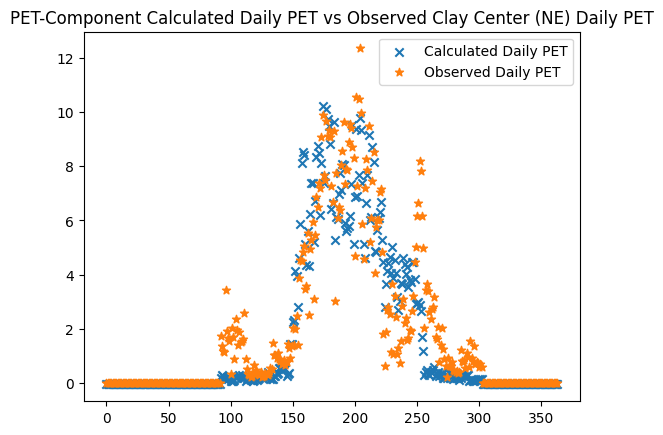

<Figure size 640x480 with 0 Axes>

In [10]:
# Plot both the calculated functions and the actual field observations
fig, axes = plt.subplots()

plt.figure() 

y = calculated_field[scatter_lb:scatter_ub]
x = exp_et[scatter_lb:scatter_ub]
# Calculate all statistical variables
nash_sutcliffe = nse(x, y)
rmse_val = rmse(x, y)

line_fit = np.poly1d(np.polyfit(x, y, 1))

# Print all stats
print("NASH SUTCLIFFE EFFICIENCY: ", nash_sutcliffe)
print("ROOT MEAN SQUARED: ", rmse_val)

axes.scatter(range(scatter_lb, scatter_ub), calculated_field[scatter_lb:scatter_ub], marker='x')
axes.scatter(range(scatter_lb, scatter_ub), exp_et[scatter_lb:scatter_ub], marker='*')

axes.set_title("PET-Component Calculated Daily PET vs Observed Clay Center (NE) Daily PET")
axes.legend(["Calculated Daily PET", "Observed Daily PET"])

plt.show()

Note the plateaus of orange and blue data from 0-70 and 300-365. Adjust scatter_lb and scatter_ub at the top of this notebook to focus in on any relevant range of data.

### Regression analysis: Generally Okay Prediction / Good Correlation
Across all 365 days, the nash sutcliffe efficiency achieved by the Penman method of the component is 0.82, which is 0.07 above the "excellent" 0.75 NSE threshold used generally for predictive models.

Observing the trend lines of the data, the ideal fit and actual linear fit lines look very close, though that is not as great of an indicator as NSE which already displays clear predictive reliability.

At the same time, the RMSE value is 1.21, indicating that there is an average predictor-observation discrepancy of 1.21mm/day, which is concerning considering this is a somewhat large amount to be off by when it comes to PET. However, for a general estimate within +/- 1mm/day, the model does just fine at taking in seasonal, topographic, and vegetation parameters to produce PET results.

One might want to check if the observed ET data was taken in a well-irrigated field as well, since the more irrigated the field is the more close the ET should be to the calculated PET. If it was not consistently well irrigated, that could also explain the 1.21 RMSE and other discrepancies between the expected vs calculated PET values.

NASH SUTCLIFFE EFFICIENCY:  0.8158236940083022
ROOT MEAN SQUARED:  1.216714750555071


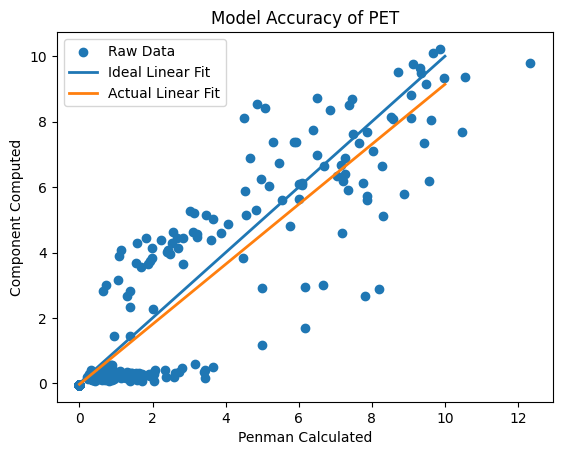

In [11]:
fig, axes = plt.subplots()

# Set labels
axes.set_xlabel("Penman Calculated")
axes.set_ylabel("Component Computed")
axes.set_title("Model Accuracy of PET")

y = calculated_field[scatter_lb:scatter_ub]
x = exp_et[scatter_lb:scatter_ub]
# Calculate all statistical variables
nash_sutcliffe = nse(x, y)
rmse_val = rmse(x, y)

line_fit = np.poly1d(np.polyfit(x, y, 1))

# Print all stats
print("NASH SUTCLIFFE EFFICIENCY: ", nash_sutcliffe)
print("ROOT MEAN SQUARED: ", rmse_val)

# Plot both the calculated functions and the actual field observations
axes.scatter(x, y)
axes.plot(np.linspace(0, 10), np.linspace(0, 10), linewidth=2)
axes.plot(np.linspace(0, 10), line_fit(np.linspace(0, 10)), linewidth=2)

axes.legend(["Raw Data", "Ideal Linear Fit", "Actual Linear Fit"])
          